In [2]:
from osgeo import gdal
import numpy as np
from tqdm import trange, tqdm
from scipy import interpolate
import random
from sklearn import model_selection, metrics

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
%run GLRLM/functions_GLRLM.py

In [5]:
%run technical_functions/geotransform_functions.py

In [6]:
%run technical_functions/ImageToNgs.py

In [7]:
%run technical_functions/cv_and_reclassification.py

In [12]:
def image_to_tensor_interp(X_pan_filename, X_mult_filename, step = 4, window_size = 55):
    
    half_size = window_size // 2
    
    X_pan = gdal.Open(X_pan_filename)
    X_mult = gdal.Open(X_mult_filename)
  #  X_pan_rasterio = rxr.open_rasterio(X_pan_filename).squeeze()
  #  X_mult_rasterio = rxr.open_rasterio(X_mult_filename)
    
    m, n = X_pan.ReadAsArray().shape
    _, m_m, m_n = X_mult.ReadAsArray().shape
    
    geo_trans_pan = X_pan.GetGeoTransform()
    geo_trans_mult = X_mult.GetGeoTransform()
    proj_pan = X_pan.GetProjection()
    proj_mult = X_mult.GetProjection()
    
    #тут нужно сделать перевод пикселей мультиканалного изображения в пиксели одноканального изображения
    pixels_pan_list = []
    for i in range(1, m_m + 1):
        a = []
        for j in range(1, m_n + 1):
            a.append((i, j))
        a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
        a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
        pixels_pan_list.append(a_pixels_in_pan)
    #теперь в pixels_list лежат листы с пикселями каждой строки
    
    mesh = np.meshgrid(np.arange(0, m_n, step), np.arange(0, m_m, step))
    values = np.zeros((mesh[0].shape[0], mesh[0].shape[1], 11))
    
     #тут нужно отсимметрить все стороны изображения, чтобы посчитать glrlm для всех пикселей исходного изображения
    img = copy.deepcopy(X_pan.ReadAsArray())
    upper_part = img[0:half_size, :]
    lower_part = img[m - half_size:m, :]
    img = np.vstack((np.flipud(upper_part), img, np.flipud(lower_part)))
    left_part = img[:, 0:half_size]
    right_part = img[:, n-half_size:n]
    img = np.hstack((np.fliplr(left_part), img, np.fliplr(right_part)))
    
    img = ImageToNgs(img, 64) - 1.
    
    for i in trange(0, len(pixels_pan_list), step): #m_m x m_n
        for j in range(0, len(pixels_pan_list[0]), step):
            x, y = pixels_pan_list[i][j]
            x = int(x + half_size - 1)
            y = int(y + half_size - 1)
            window = copy.deepcopy(img[x - half_size : x + half_size + 1, y - half_size:y + half_size + 1]).astype(int)
            GLRLM_temp = GLRLM(window)
            props = GLRLM_props(GLRLM_temp)
            values[i // step, j // step, :] = props
            
    values_interpolated = np.zeros((m_m, m_n, 11))
    for i in range(11):
        f = interpolate.interp2d(np.arange(0, m_n, step), np.arange(0, m_m, step), values[:, :, i], kind = 'linear')
        x_ = np.arange(0, m_n)
        y_ = np.arange(0, m_m)
        values_interpolated[:, :, i] = f(x_, y_)
    return values, values_interpolated

In [9]:
X_pan_filename = "geotiff/Konstantinovky_TestReg_pan.tif"
X_mult_filename = "geotiff/Konstantinovky_TestReg_mult.tif"

In [10]:
import sys
import warnings
warnings.filterwarnings("ignore")

In [20]:
v, v_i = image_to_tensor_interp(X_pan_filename, X_mult_filename)

  0%|          | 0/106 [00:00<?, ?it/s]

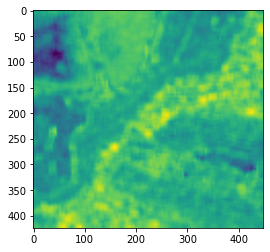

In [21]:
plt.imshow(v_i[:, :, 0])

In [23]:
np.any(np.isnan(v_i))

False

In [25]:
T = v_i

In [28]:
T.shape

(424, 448, 11)

Загружаем карту.

In [26]:
map_konst = gdal.Open('geotiff/Konstantinovsky_map.tif')
#konstantinovsky_mult = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult_gdal = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult = konstantinovsky_mult_gdal.ReadAsArray()
map_values = map_konst.ReadAsArray()
#map_konst_rasterio = rxr.open_rasterio("Konstantinovsky_map.tif").squeeze()
m_m, m_n = konstantinovsky_mult.shape[1], konstantinovsky_mult.shape[2]
geo_trans_mult = konstantinovsky_mult_gdal.GetGeoTransform()
proj_mult = konstantinovsky_mult_gdal.GetProjection()
geo_trans_pan = map_konst.GetGeoTransform()
proj_pan = map_konst.GetProjection()
pixels_pan_list = []
for i in range(1, m_m + 1):
    a = []
    for j in range(1, m_n + 1):
        a.append((i, j))
    a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
    a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
    pixels_pan_list.append(a_pixels_in_pan)
map_konst_ = np.zeros((T.shape[0], T.shape[1]))
cnt_i = 0
cnt_j = 0
for line in tqdm(pixels_pan_list):
    cnt_j = 0
    for elem in line:
        i, j = elem
        i = int(i - 1)
        j = int(j - 1)
        map_konst_[cnt_i][cnt_j] = map_values[i][j]
        cnt_j += 1
    cnt_i += 1

  0%|          | 0/424 [00:00<?, ?it/s]

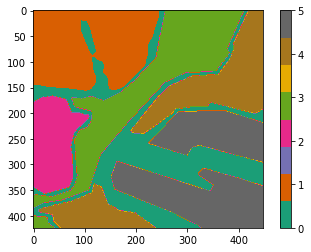

In [27]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [29]:
import skimage.io
import skimage.filters

sigma = 7.0
for i in range(11):
    T[:, :, i] = skimage.filters.gaussian(
        T[:, :, i], sigma=(sigma, sigma), truncate=3.5, multichannel=False)

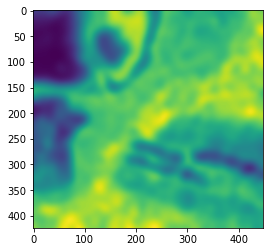

In [30]:
plt.imshow(T[:, :, 6])

In [31]:
from sklearn.preprocessing import StandardScaler
T = T.reshape((T.shape[0] * T.shape[1], 11))
scaler = StandardScaler()
T = scaler.fit_transform(T)

In [32]:
map_konst_ = map_konst_.reshape((map_konst_.shape[0] * map_konst_.shape[1], 1))

In [33]:
data = np.concatenate((T, map_konst_), axis = 1)

In [34]:
ones = data[np.argwhere(map_konst_.squeeze() == 1), :].squeeze()
data_ = np.array(random.sample(list(ones), 10000))
for i in range(2, 6):
    tmp = data[np.argwhere(map_konst_.squeeze() == i), :].squeeze()
    data_ = np.concatenate((data_, np.array(random.sample(list(tmp), 10000))), axis = 0)

In [35]:
X = data_[:, :11]
y = data_[:, 11]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0, stratify = y) 

In [39]:
qda = QuadraticDiscriminantAnalysis()

In [40]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [41]:
pred_qda = qda.predict(T.reshape(424 * 448, 11))

In [42]:
p = pred_qda.reshape((424, 448))

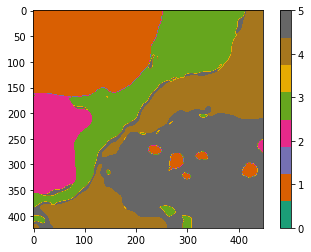

In [43]:
plt.imshow(pred_qda.reshape(424, 448), cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

In [44]:
q = QuadraticDiscriminantAnalysis()
mt = model_test(q, X_train, y_train, ['1', '2', '3', '4', '5'])
mt

(<pandas.io.formats.style.Styler at 0x7efced3a8ad0>,
 [  10-fold cross-validation                                       \
              Omission error Commission error Producer’s accuracy   
  1                 0.000000         0.000953            1.000000   
  2                 0.006510         0.008657            0.993490   
  3                 0.047486         0.014091            0.952514   
  4                 0.005163         0.015920            0.994837   
  5                 0.028923         0.047796            0.971077   
  
                     
    User’s accuracy  
  1        0.999047  
  2        0.991343  
  3        0.985909  
  4        0.984080  
  5        0.952204  ,
    Reclassification                                                     
      Omission error Commission error Producer’s accuracy User’s accuracy
  1         0.000000         0.000707            1.000000        0.999293
  2         0.006768         0.008570            0.993232        0.991430
  3       